##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Agenda:
1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import PIL
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from pathlib import Path

import glob, os
from zipfile import ZipFile

#Define Variables

In [2]:
PROJ_NBA_LOGO_DIR = "/content/Teams/"
#PROJ_NBA_LOGO_GDRIVE_DIR = "/gdrive/MyDrive/Colab Notebooks/nba logo detection/"

#PROJ_NBA_LOGO_DB_DIR = PROJ_NBA_LOGO_DIR + "db/"
#PROJ_NBA_LOGO_THUMBNAIL = PROJ_NBA_LOGO_DIR + "thumbnail/"

#PROJ_NBA_LOGO_MODEL_SAVE_GDRIVE = PROJ_NBA_LOGO_GDRIVE_DIR + "model/"
#PROJ_NBA_LOGO_MODEL_SAVE_COLAB = PROJ_NBA_LOGO_DIR + "model/"


EPOCH_TRAINING = 20  

DROP_FACTOR = 0.2

# Join paths and Create directory

In [3]:
# creating a new directory if that directory does not exist
def ensure_mkdir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

def ensure_rmtree(file_path):
    directory = os.path.dirname(file_path)
    if os.path.exists(directory):
        shutil.rmtree(directory)

In [4]:
ensure_mkdir(PROJ_NBA_LOGO_DIR)
os.chdir(PROJ_NBA_LOGO_DIR)


## Download and explore the dataset

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving NBA logo.zip to NBA logo.zip
User uploaded file "NBA logo.zip" with length 881956 bytes


In [6]:
print(os.getcwd())
with ZipFile('NBA logo.zip', 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall('dataset')



/content/Teams


In [7]:
!ls -a

 .   ..   dataset  'NBA logo.zip'


# Load using keras.preprocessing



## Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180
#num_classes=5

Let's use 80% of the images for training, and 20% for validation.

In [10]:
data_dir = PROJ_NBA_LOGO_DIR+'/dataset'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print(data_dir)

Found 50 files belonging to 5 classes.
Using 40 files for training.
/content/Teams//dataset


In [11]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 50 files belonging to 5 classes.
Using 10 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['lakers', 'mavericks', 'nets', 'pacers', 'warriors']
5


## Visualize the data

Here are the first 9 images from the training dataset.

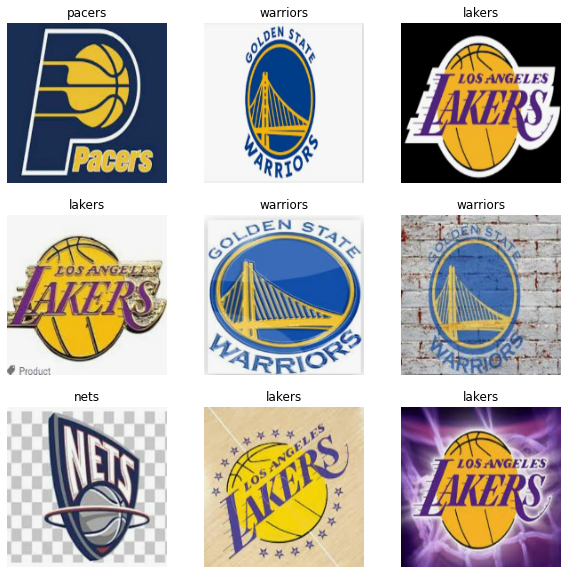

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0035984737 0.9987246


## Data augmentation

In [18]:
data_augmentation = keras.Sequential(
  [
    
    #layers.experimental.preprocessing.RandomFlip("horizontal", 
    #                                            input_shape=(img_height, 
    #                                                        img_width,
    #                                                       3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

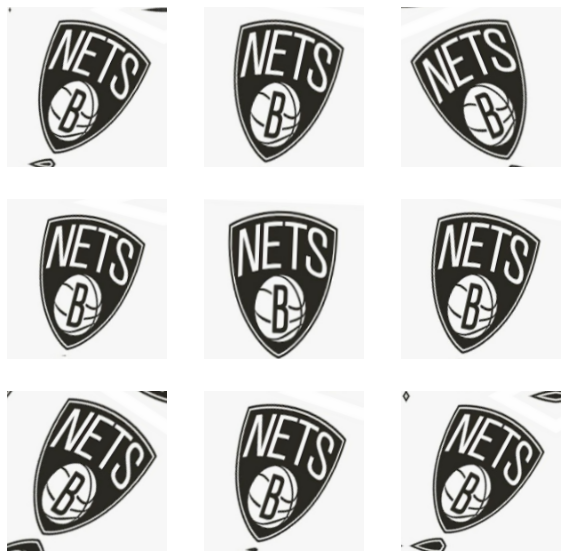

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

# Create the CNN model



In [20]:
INDEX_NUM_KERNELS = 0
INDEX_SIZE_KERNEL = 1
INDEX_SIZE_DENSE = 0

def make_seq_model(input_shape, conv_layer, dense_layer, num_classes):
  model_nm="model.seq"

  inputs = keras.Input(shape=input_shape)
  # Image augmentation block
  x = data_augmentation(inputs)
  #layers.experimental.preprocessing.Resizing()

  x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)

  # convolution layer
  if (len(conv_layer)):
    model_nm = model_nm + "-conv"
    for conv_num in range(len(conv_layer)):
      model_nm = model_nm + "_" + str(conv_layer[conv_num][INDEX_NUM_KERNELS]) + \
                          "x" + str(conv_layer[conv_num][INDEX_SIZE_KERNEL])
      x = layers.Conv2D(conv_layer[conv_num][INDEX_NUM_KERNELS], 
                        conv_layer[conv_num][INDEX_SIZE_KERNEL], 
                        padding="same")(x)
      # x = layers.BatchNormalization()(x)
      x = layers.Activation("relu")(x)
      x = layers.MaxPooling2D()(x)

  x = layers.Dropout(DROP_FACTOR)(x)

  if (len(dense_layer)):
    x = layers.Flatten()(x)

  if (len(dense_layer)):
    model_nm = model_nm + "-dense"
    for dense_num in range(len(dense_layer)):
      model_nm = model_nm + "_" + str(dense_layer[dense_num][INDEX_SIZE_DENSE])
      x = layers.Dense(dense_layer[dense_num][INDEX_SIZE_DENSE])(x)
      x = layers.Activation("relu")(x)

  # output layer
  if (num_classes == 2):
    activation = "sigmoid"
    units = 1
  else:
    #activation = "softmax"
    activation = None
    units = num_classes  

  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs), model_nm

model_nm =  model.seq-conv_32x3_64x3_128x3-dense_128


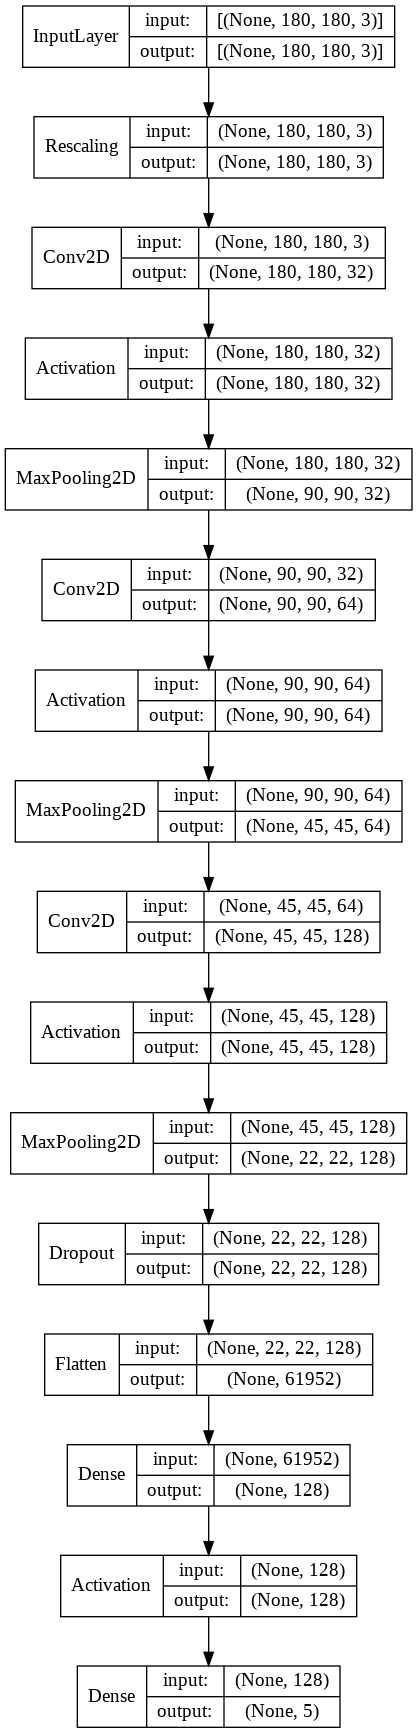

In [21]:
## convolution layers param: [# num_filters, # kernel_size]
model_1_conv =  [ [32, 3], [64, 3], [128, 3] ]
model_1_dense = [ [128]]

model_1_model, model_1_nm = make_seq_model(input_shape = (img_height, img_width, 3), 
                         conv_layer = model_1_conv, 
                         dense_layer = model_1_dense, 
                         num_classes = num_classes)
#model.append([model_1_model, model_1_nm])

print("model_nm = ", model_1_nm)
#print("model_name = ", model[num_model][INDEX_MODEL_NAME])

keras.utils.plot_model(model_1_model, show_shapes=True, show_layer_names=False)

MLP

model_nm =  model.seq-dense_256_128


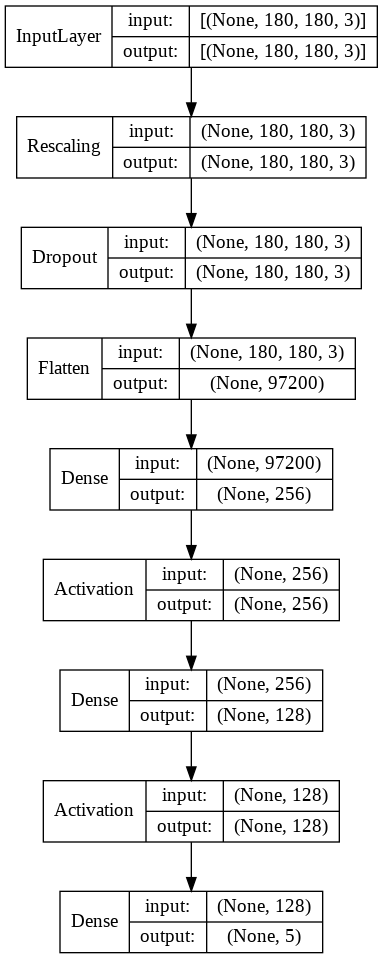

In [22]:
## convolution layers param: [# num_filters, # kernel_size]
model_2_conv =  []
model_2_dense = [ [256], [128]]

model_2_model, model_2_nm = make_seq_model(input_shape = (img_height, img_width, 3), 
                         conv_layer = model_2_conv, 
                         dense_layer = model_2_dense, 
                         num_classes = num_classes)

print("model_nm = ", model_2_nm)
#print("model_name = ", model[num_model][INDEX_MODEL_NAME])

keras.utils.plot_model(model_2_model, show_shapes=True, show_layer_names=False)

## Compile the model


In [23]:
model_1_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model_2_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

## Model summary



In [24]:
model_1_model.summary()
model_2_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 180, 180, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 90, 90, 64)        0     

## Train the CNN model

In [25]:
epochs=EPOCH_TRAINING
history = model_1_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
2/2 [==============================] - 33s 569ms/step - loss: 1.7432 - accuracy: 0.2500 - val_loss: 2.7468 - val_accuracy: 0.1000
Epoch 2/20
2/2 [==============================] - 0s 61ms/step - loss: 1.6540 - accuracy: 0.2750 - val_loss: 1.6966 - val_accuracy: 0.3000
Epoch 3/20
2/2 [==============================] - 0s 44ms/step - loss: 1.4357 - accuracy: 0.7021 - val_loss: 1.4116 - val_accuracy: 0.3000
Epoch 4/20
2/2 [==============================] - 0s 68ms/step - loss: 0.9230 - accuracy: 0.8000 - val_loss: 1.4285 - val_accuracy: 0.4000
Epoch 5/20
2/2 [==============================] - 0s 45ms/step - loss: 0.8721 - accuracy: 0.6750 - val_loss: 1.1645 - val_accuracy: 0.6000
Epoch 6/20
2/2 [==============================] - 0s 61ms/step - loss: 0.3153 - accuracy: 0.9000 - val_loss: 1.0730 - val_accuracy: 0.6000
Epoch 7/20
2/2 [==============================] - 0s 62ms/step - loss: 0.1222 - accuracy: 1.0000 - val_loss: 1.4389 - val_accuracy: 0.3000
Epoch 8/20
2/2 [=========

##Train the MLP Model

In [26]:
epochs=EPOCH_TRAINING
historyM = model_2_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
2/2 [==============================] - 0s 130ms/step - loss: 11.3377 - accuracy: 0.2167 - val_loss: 112.1458 - val_accuracy: 0.2000
Epoch 2/20
2/2 [==============================] - 0s 42ms/step - loss: 67.2039 - accuracy: 0.2917 - val_loss: 151.5033 - val_accuracy: 0.1000
Epoch 3/20
2/2 [==============================] - 0s 42ms/step - loss: 69.0986 - accuracy: 0.2333 - val_loss: 104.7120 - val_accuracy: 0.2000
Epoch 4/20
2/2 [==============================] - 0s 40ms/step - loss: 48.6946 - accuracy: 0.3083 - val_loss: 40.6173 - val_accuracy: 0.1000
Epoch 5/20
2/2 [==============================] - 0s 49ms/step - loss: 29.8329 - accuracy: 0.3542 - val_loss: 17.1090 - val_accuracy: 0.4000
Epoch 6/20
2/2 [==============================] - 0s 38ms/step - loss: 17.7627 - accuracy: 0.4354 - val_loss: 28.9276 - val_accuracy: 0.3000
Epoch 7/20
2/2 [==============================] - 0s 42ms/step - loss: 16.5616 - accuracy: 0.5542 - val_loss: 32.3426 - val_accuracy: 0.3000
Epoch 8/2

## Visualize training results (CNN)

Create plots of loss and accuracy on the training and validation sets.

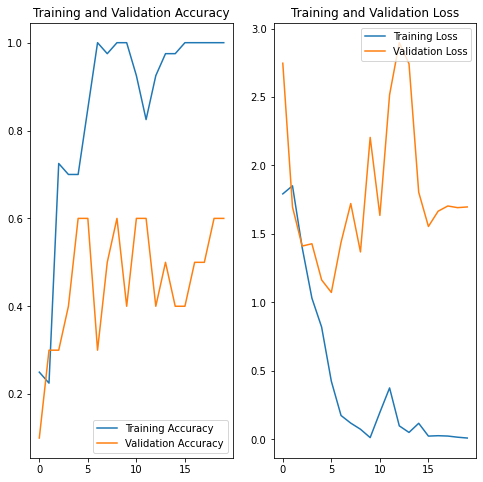

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Visualize training results (MLP)

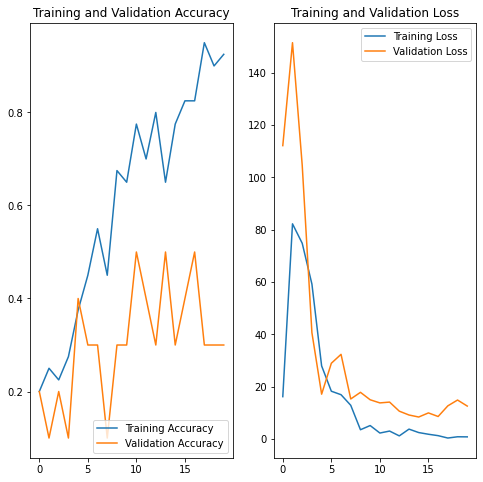

In [28]:
acc = historyM.history['accuracy']
val_acc = historyM.history['val_accuracy']

loss = historyM.history['loss']
val_loss = historyM.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Predict on new data (CNN)

Saving lakers-test01.JPG to lakers-test01.JPG
User uploaded file "lakers-test01.JPG" with length 19560 bytes
b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00x\x00x\x00\x00\xff\xe1\x10\x90Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x04\x01;\x00\x02\x00\x00\x00\n\x00\x00\x08J\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x08T\x9c\x9d\x00\x01\x00\x00\x00\x14\x00\x00\x10t\xea\x1c\x00\x07\x00\x00\x08\x0c\x00\x00\x00>\x00\x00\x00\x00\x1c\xea\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

(-0.5, 179.5, 179.5, -0.5)

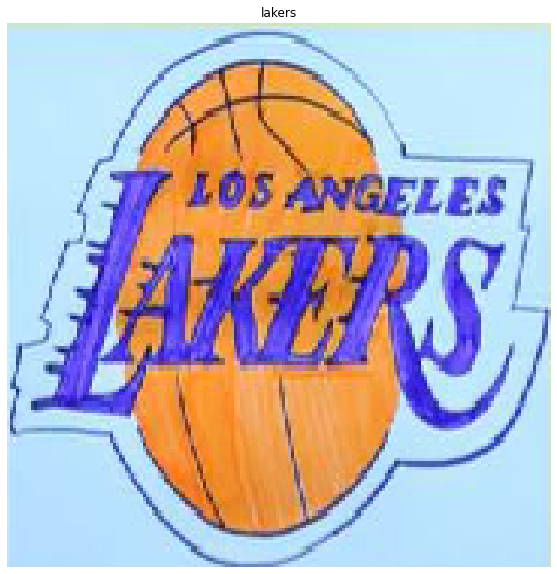

In [39]:
import os
import shutil

!rm -rf "testing"
!mkdir "testing"

model_to_try = 0



uploaded = files.upload()
## load nba logo file on the fly
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

shutil.move(fn, "./testing/")
print(uploaded[fn])

fn = "./testing/" + fn

#print(fn, "+", uploaded[fn])
print(fn)


img = keras.preprocessing.image.load_img(
    fn, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model_1_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)  

classes = np.argmax(predictions, axis = 1)
print(classes)
print(predictions)

plt.figure(figsize=(10, 10))
#plt.imshow(img.numpy().astype("uint8"))
plt.imshow(img)
plt.title(class_names[np.argmax(score)])
plt.axis("off")

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

## Predict on new data (MLP)

Saving lakers-test01.JPG to lakers-test01.JPG
User uploaded file "lakers-test01.JPG" with length 19560 bytes
b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00x\x00x\x00\x00\xff\xe1\x10\x90Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x04\x01;\x00\x02\x00\x00\x00\n\x00\x00\x08J\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x08T\x9c\x9d\x00\x01\x00\x00\x00\x14\x00\x00\x10t\xea\x1c\x00\x07\x00\x00\x08\x0c\x00\x00\x00>\x00\x00\x00\x00\x1c\xea\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

(-0.5, 179.5, 179.5, -0.5)

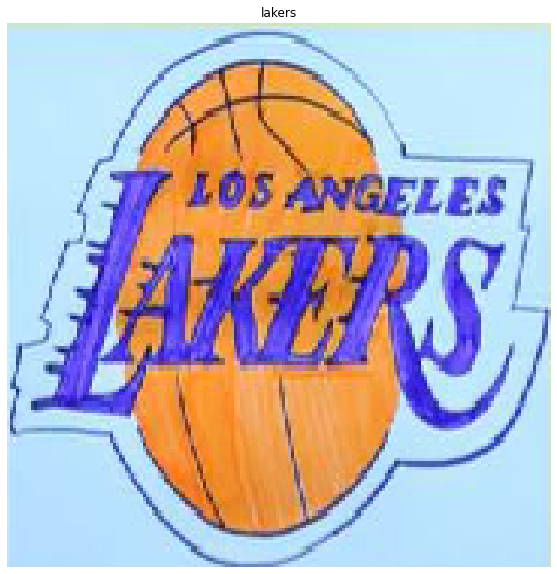

In [40]:
import os
import shutil

!rm -rf "testing"
!mkdir "testing"

model_to_try = 0



uploaded = files.upload()
## load nba logo file on the fly
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

shutil.move(fn, "./testing/")
print(uploaded[fn])

fn = "./testing/" + fn

#print(fn, "+", uploaded[fn])
print(fn)


img = keras.preprocessing.image.load_img(
    fn, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model_2_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)  

classes = np.argmax(predictions, axis = 1)
print(classes)
print(predictions)

plt.figure(figsize=(10, 10))
#plt.imshow(img.numpy().astype("uint8"))
plt.imshow(img)
plt.title(class_names[np.argmax(score)])
plt.axis("off")

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.